In [1]:
from sbdataextraction import sbdataextraction as sbd
# https://github.com/RobBlumberg/sbdataextraction

import time 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms.traversal.depth_first_search import dfs_edges
from networkx.algorithms.dag import dag_longest_path

# Analyzing pass sequences using clustering, LSTM and expected goals

## 1. Getting the data

In [2]:
league_11 = sbd.fetch_seasons_for_league(11)

Matches will be fetched for 15 seasons.
Fetching matches for season_id 4 of competition_id 11...
[=================================] 100%
Fetching matches for season_id 1 of competition_id 11...
[===================================] 100%
Fetching matches for season_id 2 of competition_id 11...
[=================================] 100%
Fetching matches for season_id 27 of competition_id 11...
[================================] 100%
Fetching matches for season_id 26 of competition_id 11...
[=====================================] 100%
Fetching matches for season_id 25 of competition_id 11...
[==============================] 100%
Fetching matches for season_id 24 of competition_id 11...
[===============================] 100%
Fetching matches for season_id 23 of competition_id 11...
[====================================] 100%
Fetching matches for season_id 22 of competition_id 11...
[================================] 100%
Fetching matches for season_id 21 of competition_id 11...
[===========

In [3]:
season_11_21 = sbd.fetch_matches_for_season(11, 21)

Fetching matches for season_id 21 of competition_id 11...
[==================================] 100%


### 1.1 Make events dataframe for all events in the season / league

In [4]:
# add these functions to sbdataextraction package when I have time
def get_season_events_df(season_dict):
    """
    
    """
    game1_key = list(season_dict.keys())[0]
    season_event_df = season_dict[game1_key].get_events_for_game()
    
    for game_id, game in season_dict.items():
        event_df = game.get_events_for_game()
        if game_id != game1_key:
            season_event_df = season_event_df.append(event_df)
            
    season_event_df["time"] = pd.to_datetime(season_event_df["time"])
    without_date = season_event_df['time'].apply(lambda d : d.time())
    season_event_df['time'] = without_date
    
    return season_event_df

def get_league_events_df(league_dict):
    """
    
    """
    season1_key = list(league_dict.keys())[0]
    print(f"Getting events for season {season1_key}...")
    league_event_df = get_season_events_df(league_dict[season1_key])
    
    for season_id, season_dict in league_dict.items():
        if season_id != season1_key:
            print(f"Getting events for season {season_id}...")
            season_df = get_season_events_df(season_dict)
            league_event_df = league_event_df.append(season_df)
        
    return league_event_df

In [5]:
league_events_df = get_league_events_df(league_11)

Getting events for season 2018/2019...
Getting events for season 2017/2018...
Getting events for season 2016/2017...
Getting events for season 2015/2016...
Getting events for season 2014/2015...
Getting events for season 2013/2014...
Getting events for season 2012/2013...
Getting events for season 2011/2012...
Getting events for season 2010/2011...
Getting events for season 2009/2010...
Getting events for season 2008/2009...
Getting events for season 2007/2008...
Getting events for season 2006/2007...
Getting events for season 2005/2006...
Getting events for season 2004/2005...


In [6]:
season_11_21_events_df = get_season_events_df(season_11_21)

In [7]:
print(season_11_21_events_df.shape)
print(league_events_df.shape)

(98863, 12)
(1317861, 12)


### 1.2 Make graph of related events

In [8]:
# also add these functions to sbdataextraction
def get_event_graphs_for_season(season_dict):
    """
    
    """
    game_event_graphs = {}
    for game_id, game in season_dict.items():
        events_graph = nx.Graph()
        events_graph.add_nodes_from(game.event_df.index)

        for index, row in game.event_df.iterrows():
            if row["related events"] is not None:
                events_graph.add_edges_from([(index, x) for x in row["related events"] 
                                             if (x in game.event_df.index) # and 
                                             #    season_event_df.loc[index]["time"] < season_event_df.loc[x]["time"])
                                            ])

        game_event_graphs[game_id] = events_graph
        
    return game_event_graphs

def get_event_graphs_for_league(league_dict):
    """
    
    """
    game_event_graphs = {}
    for season_id, season_dict in league_dict.items():
        print(f"Getting event graph for season {season_id}...")
        event_graphs = get_event_graphs_for_season(season_dict)
        game_event_graphs = {**game_event_graphs, **event_graphs}
    
    return game_event_graphs

season_11_21_events_graph = get_event_graphs_for_season(season_11_21)
league_events_graph = get_event_graphs_for_league(league_11)

Getting event graph for season 2018/2019...
Getting event graph for season 2017/2018...
Getting event graph for season 2016/2017...
Getting event graph for season 2015/2016...
Getting event graph for season 2014/2015...
Getting event graph for season 2013/2014...
Getting event graph for season 2012/2013...
Getting event graph for season 2011/2012...
Getting event graph for season 2010/2011...
Getting event graph for season 2009/2010...
Getting event graph for season 2008/2009...
Getting event graph for season 2007/2008...
Getting event graph for season 2006/2007...
Getting event graph for season 2005/2006...
Getting event graph for season 2004/2005...


### 1.3 Get all event sequences from graphs 

In [9]:
all_sequences = []
game_num = 0
for game_id, event_graph in league_events_graph.items():
    if game_num % 100 == 0:
        print(f"Getting sequences for games {game_num} to {game_num+100}...")
    game_sequences = []
    for components in list(nx.connected_components(event_graph)):
        components_order_df = league_events_df.loc[list(components)]["time"]
        components_sorted = list(components_order_df.sort_values().index)
        game_sequences.append(components_sorted)
    all_sequences.append(game_sequences)
    game_num +=1

Getting sequences for games 0 to 100...
Getting sequences for games 100 to 200...
Getting sequences for games 200 to 300...
Getting sequences for games 300 to 400...
Getting sequences for games 400 to 500...


In [10]:
all_sequences[0][1]

['1f530275-9468-4f26-8d9c-e66855c263ad',
 '8e3ad3a7-39fe-4d97-85b1-b7402975974c',
 '96c8a55c-fff2-4d1f-a054-2b9d94ac35c5',
 '922fc5e2-6854-49fe-b140-beed35664c5e',
 'bd775132-7582-421f-9bc3-a57f16d368da',
 '1596436b-b393-4e5b-b442-957c1c62b201',
 'f3f7bbf5-b275-48e0-974b-060b429b7bb0']

In [11]:
league_events_df.loc[all_sequences[0][1]]

time     event name  team_id  \
event id                                                                        
1f530275-9468-4f26-8d9c-e66855c263ad  00:00:55.498000           pass      218   
8e3ad3a7-39fe-4d97-85b1-b7402975974c  00:00:56.361000  ball receipt*      218   
96c8a55c-fff2-4d1f-a054-2b9d94ac35c5  00:00:56.361000          carry      218   
922fc5e2-6854-49fe-b140-beed35664c5e  00:00:57.513000           pass      218   
bd775132-7582-421f-9bc3-a57f16d368da  00:00:59.236000  ball receipt*      218   
1596436b-b393-4e5b-b442-957c1c62b201  00:00:59.236000          carry      218   
f3f7bbf5-b275-48e0-974b-060b429b7bb0  00:00:59.276000           pass      218   

                                       team_name  player_id  \
event id                                                      
1f530275-9468-4f26-8d9c-e66855c263ad  Real Betis       3313   
8e3ad3a7-39fe-4d97-85b1-b7402975974c  Real Betis       6651   
96c8a55c-fff2-4d1f-a054-2b9d94ac35c5  Real Betis       6651   
922fc5e2-6854-49fe-b140-beed35664c5e  Real Betis       6651   
bd775132-7582-421f-9bc3-a57f16d368da  Real Betis       6673   
1596436b-b393-4e5b-b442-957c1c62b201  Real Betis       6673   
f3f7bbf5-b275-48e0-974b-060b429b7bb0  Real Betis       6673   

                                                    player_name  \
event id                                                          
1f530275-9468-4f26-8d9c-e66855c263ad           Giovani Lo Celso   
8e3ad3a7-39fe-4d97-85b1-b7402975974c  Joaquín Sánchez Rodríguez   
96c8a55c-fff2-4d1f-a054-2b9d94ac35c5  Joaquín Sánchez Rodríguez   
922fc5e2-6854-49fe-b140-beed35664c5e  Joaquín Sánchez Rodríguez   
bd775132-7582-421f-9bc3-a57f16d368da     Sergio Canales Madrazo   
1596436b-b393-4e5b-b442-957c1c62b201     Sergio Canales Madrazo   
f3f7bbf5-b275-48e0-974b-060b429b7bb0     Sergio Canales Madrazo   

                                      x start location  y start location  \
event id                                                                   
1f530275-9468-4f26-8d9c-e66855c263ad             120.0              80.0   
8e3ad3a7-39fe-4d97-85b1-b7402975974c             115.0              75.0   
96c8a55c-fff2-4d1f-a054-2b9d94ac35c5             115.0              75.0   
922fc5e2-6854-49fe-b140-beed35664c5e             113.0              72.0   
bd775132-7582-421f-9bc3-a57f16d368da             106.0              64.0   
1596436b-b393-4e5b-b442-957c1c62b201             106.0              64.0   
f3f7bbf5-b275-48e0-974b-060b429b7bb0             106.0              64.0   

                                      x end location  y end location  \
event id                                                               
1f530275-9468-4f26-8d9c-e66855c263ad           115.0            75.0   
8e3ad3a7-39fe-4d97-85b1-b7402975974c            -1.0            -1.0   
96c8a55c-fff2-4d1f-a054-2b9d94ac35c5           113.0            72.0   
922fc5e2-6854-49fe-b140-beed35664c5e           106.0            64.0   
bd775132-7582-421f-9bc3-a57f16d368da            -1.0            -1.0   
1596436b-b393-4e5b-b442-957c1c62b201           106.0            64.0   
f3f7bbf5-b275-48e0-974b-060b429b7bb0           112.0            44.0   

                                      statsbomb xg  \
event id                                             
1f530275-9468-4f26-8d9c-e66855c263ad          -1.0   
8e3ad3a7-39fe-4d97-85b1-b7402975974c          -1.0   
96c8a55c-fff2-4d1f-a054-2b9d94ac35c5          -1.0   
922fc5e2-6854-49fe-b140-beed35664c5e          -1.0   
bd775132-7582-421f-9bc3-a57f16d368da          -1.0   
1596436b-b393-4e5b-b442-957c1c62b201          -1.0   
f3f7bbf5-b275-48e0-974b-060b429b7bb0          -1.0   

                                                                         related events  
event id                                                                                 
1f530275-9468-4f26-8d9c-e66855c263ad             [8e3ad3a7-39fe-4d97-85b1-b7402975974c]  
8e3ad3a7-39fe-4d97-85b1-b7402975974c             [1f5302

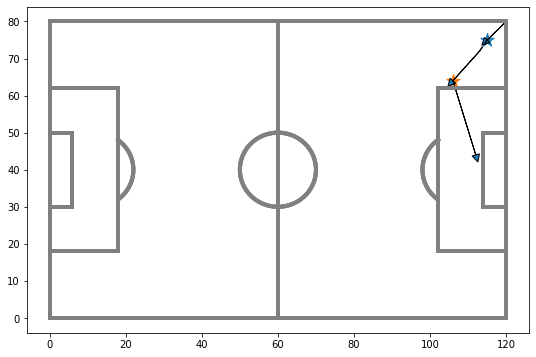

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
for event in all_sequences[0][1]:
    sbd.draw_pitch(axis=ax, rotate=True)
    sbd.plot_event(league_11["2018/2019"][16215], event, axis=ax)

## 2. Pass clustering

### 2.1 Preparing data

In [13]:
import math
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [14]:
league_pass_df = league_events_df[league_events_df["event name"] == "pass"].iloc[:, 6:10]
x1 = league_pass_df["x start location"]
x2 = league_pass_df["x end location"]
y1 = league_pass_df["y start location"]
y2 = league_pass_df["y end location"]
league_pass_df["length"] = np.sqrt((x2-x1)**2 + (y2-y1)**2)
league_pass_df["angle"] = list(map(lambda x, y: math.atan2(x, y), x2-x1, y2-y1))
league_pass_df

x start location  y start location  \
event id                                                                   
63a0b71c-9d24-432b-90d9-bcab133ec115              60.0              40.0   
7fe2a2af-eaae-4828-8ffb-cc950067a400              56.0              33.0   
ba443562-2a24-4eee-b313-4186fae40408              44.0              26.0   
bf317d5d-e16c-48de-aa76-06a564b92dae              41.0              38.0   
24e00354-7f92-403f-ac82-491953cca022              41.0              55.0   
...                                                ...               ...   
9ce81521-4c28-44ef-9b5c-fde00d221767              78.0              68.5   
66c68e07-9ee3-40c2-b696-7101ec9b74ea              24.5              57.9   
ca83c801-c6ba-47ea-b9c4-382848bde5fd              15.0              52.7   
2d384fac-00f7-4bfd-ba8b-6819cbe139c3              37.3              72.6   
7b06f176-3ed4-4b06-ac35-6cd7b749adf0              93.2               4.6   

                                      x end location  y end location  \
event id                                                               
63a0b71c-9d24-432b-90d9-bcab133ec115            54.0            38.0   
7fe2a2af-eaae-4828-8ffb-cc950067a400            44.0            26.0   
ba443562-2a24-4eee-b313-4186fae40408            36.0            37.0   
bf317d5d-e16c-48de-aa76-06a564b92dae            41.0            55.0   
24e00354-7f92-403f-ac82-491953cca022            32.0            41.0   
...                                              ...             ...   
9ce81521-4c28-44ef-9b5c-fde00d221767           107.7            24.3   
66c68e07-9ee3-40c2-b696-7101ec9b74ea            15.2            52.7   
ca83c801-c6ba-47ea-b9c4-382848bde5fd            37.3            72.6   
2d384fac-00f7-4bfd-ba8b-6819cbe139c3            28.7            68.7   
7b06f176-3ed4-4b06-ac35-6cd7b749adf0            88.7            37.4   

                                         length     angle  
event id                                                   
63a0b71c-9d24-432b-90d9-bcab133ec115   6.324555 -1.892547  
7fe2a2af-eaae-4828-8ffb-cc950067a400  13.892444 -2.098871  
ba443562-2a24-4eee-b313-4186fae40408  13.601471 -0.628796  
bf317d5d-e16c-48de-aa76-06a564b92dae  17.000000  0.000000  
24e00354-7f92-403f-ac82-491953cca022  16.643317 -2.570255  
...                                         ...       ...  
9ce81521-4c28-44ef-9b5c-fde00d221767  53.251573  2.549944  
66c68e07-9ee3-40c2-b696-7101ec9b74ea  10.655046 -2.080630  
ca83c801-c6ba-47ea-b9c4-382848bde5fd  29.888125  0.842209  
2d384fac-00f7-4bfd-ba8b-6819cbe139c3   9.442987 -1.996547  
7b06f176-3ed4-4b06-ac35-6cd7b749adf0  33.107250 -0.136344  

[469160 rows x 6 columns]

**Here, I scale the feature with a standard scaler**

In [15]:
cols = ["x start location", "y start location", "length", "angle"]
ss = StandardScaler()
league_pass_df_transformed = ss.fit_transform(league_pass_df[cols])
league_pass_df_transformed

array([[-0.00406889, -0.02914856, -1.01288105, -1.31450033],
       [-0.15388682, -0.33506945, -0.47625582, -1.43043892],
       [-0.60334062, -0.64099034, -0.49688822, -0.60436704],
       ...,
       [-1.68952064,  0.52587935,  0.6579688 ,  0.22222788],
       [-0.85428566,  1.39556874, -0.79175874, -1.37294084],
       [ 1.23941995, -1.5762342 ,  0.88623112, -0.32764566]])

### 2.2 Cluster with Mini-batch Kmeans

In [16]:
n_cluster = 400
kmeans = MiniBatchKMeans(n_clusters=n_cluster, batch_size=10000, n_init=10)
kmeans.fit_predict(league_pass_df_transformed);

In [17]:
league_pass_df["cluster"] = kmeans.labels_

### 2.2 Plot clusters 

- Below I plot cluster centers and example passes from 2018/2019 season

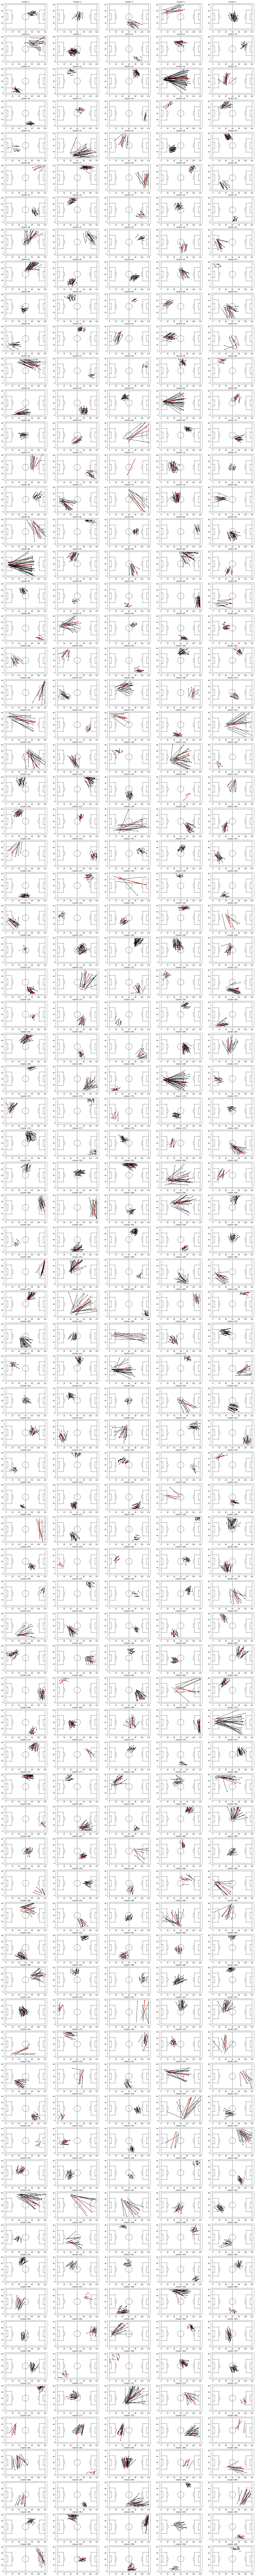

In [18]:
axis_cols = 5
axis_rows = int(np.ceil(n_cluster / axis_cols))
fig, axs = plt.subplots(axis_rows, axis_cols, figsize=(30, 0.66*(30/axis_cols)*axis_rows))
ax = axs.reshape(-1)
# create cluster plots with pitch
for i, axi in enumerate(ax):
    sbd.draw_pitch(axis=axi, rotate=True)
    axi.set_title(f"cluster {i+1}", size=12)
    
# plot passes from 2018/2019 season
for game_id, game in league_11['2004/2005'].items():
    event_df_game = game.event_df
    pass_df_game = event_df_game[event_df_game["event name"] == "pass"]
    for index, row, in pass_df_game.iterrows():
        axis_num = int(league_pass_df.loc[index]["cluster"])
        sbd.plot_event(game, index, axis=ax[axis_num])

# plot cluster centers
for i, pass_coords in enumerate(ss.inverse_transform(kmeans.cluster_centers_)):
    ax[i].arrow(pass_coords[0], pass_coords[1], pass_coords[2]*np.sin(pass_coords[3]), pass_coords[2]*np.cos(pass_coords[3]),
                head_width=2, linewidth=2, color="red")

## 3. Rating passes with xg

### 3.1 xG for each sequence

- The xG of a sequence is given by the xG of the shot it lead to. If sequence didn't lead to a shot, xG is 0.

In [19]:
all_sequences_xg = []
for game_sequences in all_sequences:
    for sequence in game_sequences:
        xg = 0
        for event_id in sequence:
            if league_events_df.loc[event_id]["event name"] == "shot":
                xg = league_events_df.loc[event_id]["statsbomb xg"]
        all_sequences_xg.append(xg)

### 3.2 xG for events

- The xG of an event is given by the xG of the sequence the event was in

In [20]:
event_xg_dict = {}
for game_sequences in all_sequences:
    for i, sequence in enumerate(game_sequences):
        for event_id in sequence:
            event_xg_dict[event_id] = all_sequences_xg[i]

### 3.3 xG for passes

In [22]:
pass_xg_column = []
for index, row in league_pass_df.iterrows():
    xg = event_xg_dict[index]
    pass_xg_column.append(xg)
league_pass_df["event xg"] = pass_xg_column

**Average xG per pass cluster:**

In [125]:
cluster_avg_exg = league_pass_df.groupby("cluster").mean().sort_values("event xg", ascending=False)
cluster_avg_exg.index = cluster_avg_exg.index + 1 # so that first cluster is labelled with 1, not 0
cluster_avg_exg

x start location  y start location  x end location  y end location  \
cluster                                                                       
236             97.577876         71.081416      111.874336        7.222124   
106            115.896651         73.868421      102.405263       15.300957   
139             53.670717         75.442045       59.069056       72.675524   
138             26.632948         64.780347      105.039884       43.712139   
339            105.386620         75.829577      108.453119       69.721127   
...                   ...               ...             ...             ...   
113             13.443902         70.561247       49.615854       63.203930   
246            113.300131         56.441623      110.430366       50.507199   
189             38.527901         53.101381       84.838674       59.232459   
381             33.595851         62.447994       41.646058       27.781051   
262             24.990528         70.838434       16.950273       72.334244   

            length     angle  event xg  
cluster                                 
236      66.230443  2.921647  0.024574  
106      60.936498 -2.914955  0.021135  
139       6.491749  2.030100  0.017653  
138      86.234025  1.833080  0.017395  
339       7.337474  2.666862  0.017394  
...            ...       ...       ...  
113      39.769746  1.780066  0.007477  
246       7.006519 -2.681521  0.007345  
189      49.632230  1.440223  0.007243  
381      36.573289  2.910236  0.006459  
262       9.041389 -1.372774  0.005328  

[400 rows x 7 columns]

## 4. RNN

### 4.1 Data prep

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, LSTM, Dropout
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


**IMPORTANT:** Cluster indices in pass_sequence list will be 1 greater than cluster indices given by Kmeans.

In [25]:
pass_sequences = []
for game_sequence in all_sequences:
    for sequence in game_sequence:
        pass_sequence = []
        for event in sequence:
            if event in league_pass_df.index:
                pass_sequence.append(1+league_pass_df.loc[event]["cluster"])
        pass_sequences.append(pass_sequence)

**Map xg to sequences and remove sequences with no passes:**

In [26]:
pass_seq_xg_df = pd.DataFrame({"pass seq" : pass_sequences, "xg" : all_sequences_xg})
seq_len_mask = pass_seq_xg_df["pass seq"].apply(lambda x: len(x) > 0)
pass_seq_xg_df = pass_seq_xg_df.loc[seq_len_mask]
pass_seq_xg_df

pass seq   xg
0       [218.0, 66.0, 191.0, 319.0, 179.0, 346.0, 185....  0.0
1                                   [239.0, 371.0, 204.0]  0.0
2                     [279.0, 100.0, 121.0, 352.0, 267.0]  0.0
3                                           [319.0, 91.0]  0.0
4        [218.0, 151.0, 110.0, 216.0, 344.0, 254.0, 93.0]  0.0
...                                                   ...  ...
174668                                             [38.0]  0.0
174669  [95.0, 42.0, 21.0, 337.0, 240.0, 276.0, 13.0, ...  0.0
174670                        [309.0, 201.0, 271.0, 81.0]  0.0
174671                               [142.0, 278.0, 19.0]  0.0
174673                                            [167.0]  0.0

[157149 rows x 2 columns]

**Pad sequences with 0s**

In [27]:
padded_sequence = np.reshape(pad_sequences(pass_seq_xg_df["pass seq"].to_list()), 
                            (pad_sequences(pass_seq_xg_df["pass seq"].to_list()).shape[0], 
                             pad_sequences(pass_seq_xg_df["pass seq"].to_list()).shape[1]))

In [28]:
n_last_passes = 3
padded_sequence = padded_sequence[:, -n_last_passes:]

**Split into training, validation and test sets:**

In [29]:
train_prop = 0.75
val_prop = 0.15
n_sequences = padded_sequence.shape[0]

shuffled_indices = np.random.choice(n_sequences, n_sequences, replace=False)
train_ind = shuffled_indices[0:int(n_sequences*train_prop)]
val_ind = shuffled_indices[int(n_sequences*train_prop):int(n_sequences*train_prop)+int(n_sequences*val_prop)]
test_ind = shuffled_indices[int(n_sequences*train_prop)+int(n_sequences*val_prop):]

X_train = padded_sequence[train_ind]
X_val = padded_sequence[val_ind]
X_test = padded_sequence[test_ind]

In [30]:
y_train = pass_seq_xg_df["xg"].to_numpy()[train_ind]
y_val = pass_seq_xg_df["xg"].to_numpy()[val_ind]
y_test = pass_seq_xg_df["xg"].to_numpy()[test_ind]

**Use cluster features:**

In [31]:
X_train_vec = np.ones((X_train.shape[0], X_train.shape[1], 4))
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
        vec = kmeans.cluster_centers_[X_train[i, j]-1]
        X_train_vec[i, j] = vec

X_val_vec = np.ones((X_val.shape[0], X_val.shape[1], 4))
for i in range(X_val.shape[0]):
    for j in range(X_val.shape[1]):
        vec = kmeans.cluster_centers_[X_val[i, j]-1]
        X_val_vec[i, j] = vec
        
X_test_vec = np.ones((X_test.shape[0], X_test.shape[1], 4))
for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
        vec = kmeans.cluster_centers_[X_test[i, j]-1]
        X_test_vec[i, j] = vec

### 4.2 Build LSTM model

In [63]:
model = Sequential()
#model.add(Embedding(n_cluster+1, 300, mask_zero=True))   # for cluster num
#model.add(LSTM(256, activation='tanh'))                  # for cluster num
model.add(LSTM(256, input_dim=4, activation='tanh'))      # for cluster features
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               267264    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________


In [64]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=3)
model.fit(X_train_vec, y_train, epochs=30, verbose=1, batch_size=100, validation_data=(X_val_vec, y_val), callbacks=[callback])

Epoch 1/30
1179/1179 [==============================] - 15s 12ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 2/30
1179/1179 [==============================] - 15s 13ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 3/30
1179/1179 [==============================] - 15s 13ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 4/30
1179/1179 [==============================] - 16s 13ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 5/30
1179/1179 [==============================] - 15s 13ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 6/30
1179/1179 [==============================] - 15s 13ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoc

In [66]:
sequence_xg_pred = model.predict(X_test_vec)

In [72]:
sequence_score_df = pd.DataFrame({"seq": [list(x) for x in X_test], "score" : sequence_xg_pred.flatten()}).sort_values("score", ascending=False)
sequence_score_df.head(10)

seq     score
9815     [87, 264, 84]  0.077030
2139      [0, 109, 84]  0.074795
14948     [0, 22, 132]  0.070202
13094   [374, 187, 84]  0.068061
2953     [0, 388, 132]  0.066419
5863     [249, 76, 84]  0.065622
6985   [161, 396, 132]  0.065413
14701  [126, 189, 186]  0.065330
853        [0, 71, 84]  0.064866
10235     [10, 76, 84]  0.062061

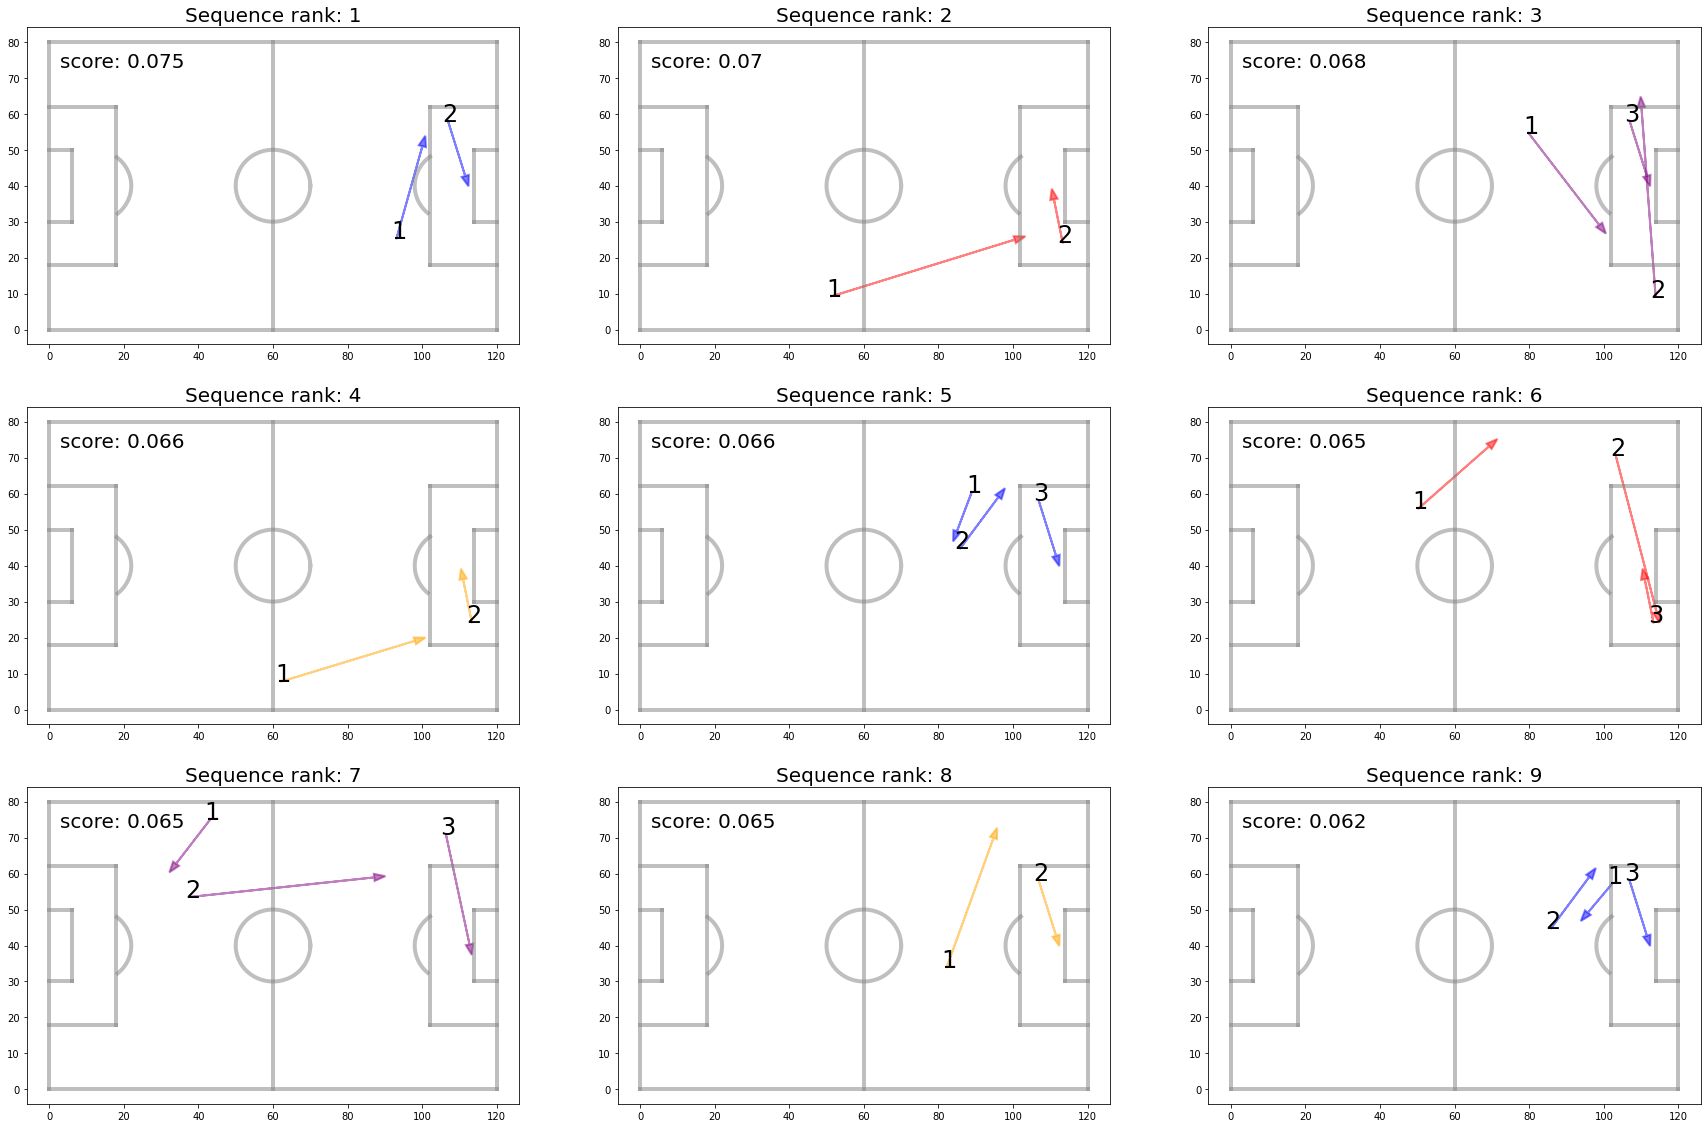

In [134]:
per_row = 3
start_rank = 1
end_rank = 9
n_seq = end_rank - start_rank + 1
fig, axs = plt.subplots(int(np.ceil(n_seq / per_row)), per_row, figsize=(30, 0.66*(30/per_row)*np.ceil(n_seq / per_row)))
ax = axs.reshape(-1)


colors = ["blue", "red", "purple", "orange"]
c = 0
rank = start_rank
for index, row in sequence_score_df.iloc[start_rank:end_rank+1].iterrows():
    sbd.draw_pitch(axis=ax[c], rotate=True)
    ax[c].annotate(f"score: {round(row['score'], 3)}", (3, 73), size=20)
    ax[c].set_title(f"Sequence rank: {rank}", size=20)
    pass_order = 1
    for pass_cl in row["seq"]:
        pass_coords = ss.inverse_transform(kmeans.cluster_centers_[pass_cl-1])
        if pass_cl != 0:
            ax[c].arrow(pass_coords[0], pass_coords[1], pass_coords[2]*np.sin(pass_coords[3]), pass_coords[2]*np.cos(pass_coords[3]),
                     head_width=2, linewidth=2, color=colors[c%len(colors)], alpha=0.5)
            ax[c].annotate(f"{pass_order}", (pass_coords[0]-1.5, pass_coords[1]), size=24)  
            pass_order+=1
    c+=1
    rank+=1
    
plt.savefig("lstm-highest-xg.png")

In [133]:
#plt.savefig("lstm-highest-xg.png")

<Figure size 432x288 with 0 Axes>

## Appendix: importance of pass groups

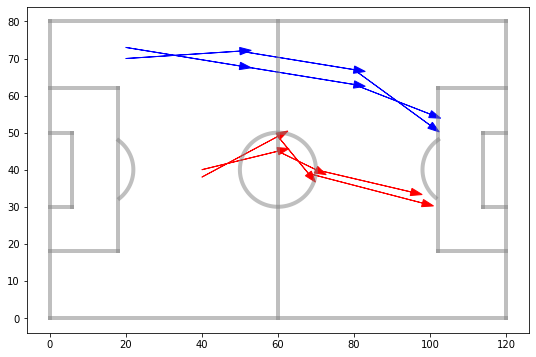

In [174]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
sbd.draw_pitch(axis=ax, rotate=True)
ax.arrow(20, 70, 30, 2, head_width=2, color="blue")
ax.arrow(50, 72, 30, -5, head_width=2, color="blue")
ax.arrow(80, 67, 20, -15, head_width=2, color="blue")

ax.arrow(20, 73, 30, -5, head_width=2, color="blue")
ax.arrow(50, 68, 30, -5, head_width=2, color="blue")
ax.arrow(80, 63, 20, -8, head_width=2, color="blue")

ax.arrow(40, 40, 20, 5, head_width=2, color="red")
ax.arrow(60, 45, 10, -5, head_width=2, color="red")
ax.arrow(70, 40, 25, -6, head_width=2, color="red")

ax.arrow(40, 38, 20, 11, head_width=2, color="red")
ax.arrow(60, 49, 8, -10, head_width=2, color="red")
ax.arrow(68, 39, 30, -8, head_width=2, color="red")

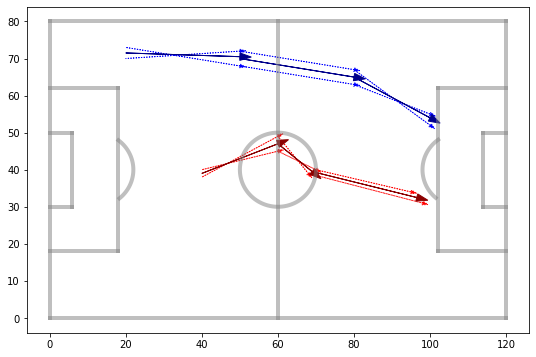

In [228]:
alpha = 1
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
sbd.draw_pitch(axis=ax, rotate=True)
hw1 = 1
ax.arrow(20, 70, 30, 2, head_width=hw1, color="blue", alpha=alpha, linestyle=':')
ax.arrow(50, 72, 30, -5, head_width=hw1, color="blue", alpha=alpha, linestyle=':')
ax.arrow(80, 67, 20, -15, head_width=hw1, color="blue", alpha=alpha, linestyle=':')

ax.arrow(20, 73, 30, -5, head_width=hw1, color="blue", alpha=alpha, linestyle=':')
ax.arrow(50, 68, 30, -5, head_width=hw1, color="blue", alpha=alpha, linestyle=':')
ax.arrow(80, 63, 20, -8, head_width=hw1, color="blue", alpha=alpha, linestyle=':')

ax.arrow(40, 40, 20, 5, head_width=hw1, color="red", alpha=alpha, linestyle=':')
ax.arrow(60, 45, 10, -5, head_width=hw1, color="red", alpha=alpha, linestyle=':')
ax.arrow(70, 40, 25, -6, head_width=hw1, color="red", alpha=alpha, linestyle=':')

ax.arrow(40, 38, 20, 11, head_width=hw1, color="red", alpha=alpha, linestyle=':')
ax.arrow(60, 49, 8, -10, head_width=hw1, color="red", alpha=alpha, linestyle=':')
ax.arrow(68, 39, 30, -8, head_width=hw1, color="red", alpha=alpha, linestyle=':')

hw2 = 2
ax.arrow(20, 71.5, 30, -1, head_width=hw2, color="darkblue", alpha=1)
ax.arrow(50, 70, 30, -5, head_width=hw2, color="darkblue", alpha=1)
ax.arrow(80, 65, 20, -11, head_width=hw2, color="darkblue", alpha=1)

ax.arrow(40, 39, 20, 8, head_width=hw2, color="darkred", alpha=1)
ax.arrow(60, 47, 9, -7.5, head_width=hw2, color="darkred", alpha=1)
ax.arrow(69, 39.5, 27.5, -7, head_width=hw2, color="darkred", alpha=1)